In [1]:
!pip install torch torchvision torchmetrics torch-fidelity numpy matplotlib scikit-image
!pip install pytorch-fid
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision
import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from datetime import datetime
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.backends.cudnn.benchmark = True

drive.mount('/content/gdrive')
folder_path = '/content/gdrive/MyDrive/2025 SP/Outputs' # to grader: update this!!

class RestorationNetwork(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, hidden_channels, 3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.ReLU(inplace=True)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(hidden_channels * 2, hidden_channels * 2, 3, padding=1),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels * 2, hidden_channels * 2, 3, padding=1),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(hidden_channels * 2, hidden_channels, 3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, in_channels, 3, padding=1)
        )

    def forward(self, x, t):
        batch_size = x.size(0)
        t_embed = t.view(batch_size, 1, 1, 1).expand(batch_size, 1, x.size(2), x.size(3))
        x = torch.cat([x, t_embed], dim=1)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        m = self.middle(e2)
        d2 = self.dec2(m)
        d1 = self.dec1(torch.cat([d2, e1], dim=1))
        return d1

class EMA:
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

Using device: cuda
Mounted at /content/gdrive


In [4]:
BATCH_SIZE = 256 # from 64
LEARNING_RATE = 2e-5
TOTAL_TRAIN_STEPS = 5_000 # from 60_000
GRAD_ACCUM_STEPS = 2
EMA_DECAY = 0.995
EMA_UPDATE_FREQ = 10
NUM_TIMESTEPS = 50

def generate_gaussian_mask(h, w, beta, center=None, device='cpu'):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    y = y.to(device).float()
    x = x.to(device).float()
    if center is None:
        center_x = torch.randint(0, w, (1,)).item()
        center_y = torch.randint(0, h, (1,)).item()
    else:
        center_x, center_y = center
    gaussian = torch.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * beta))
    mask = 1 - gaussian / gaussian.max()
    return mask

def degrade_inpainting(x, t, dataset_name, center=(16, 16)):
    b, c, h, w = x.shape
    device = x.device

    beta1 = 5.0
    betas = [beta1 + 0.1 * i for i in range(NUM_TIMESTEPS)]

    t_indices = t.long().clamp(1, NUM_TIMESTEPS) - 1
    beta_batch = torch.tensor([betas[i] for i in t_indices], device=device)

    center_x = torch.full((b,), center[0], device=device)
    center_y = torch.full((b,), center[1], device=device)
    y_coords, x_coords = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    y_coords = y_coords.expand(b, -1, -1)
    x_coords = x_coords.expand(b, -1, -1)

    dist_sq = (x_coords - center_x[:, None, None])**2 + (y_coords - center_y[:, None, None])**2
    beta_expanded = beta_batch[:, None, None]
    gaussians = torch.exp(-dist_sq / (2 * beta_expanded))
    masks = 1 - (gaussians / gaussians.amax(dim=(1, 2), keepdim=True))
    masks = masks.unsqueeze(1)  # (B, 1, H, W)

    degraded = x * masks
    degraded = torch.round(degraded * 1e8) / 1e8
    return degraded


def get_dataset(dataset_name, root='./data'):
    if dataset_name == 'MNIST':
        transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_dataset = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root=root, train=False, download=True, transform=transform)
    elif dataset_name == 'CIFAR10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    return train_dataset, test_dataset

def train_model(model, train_loader, dataset_name, device):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.L1Loss()
    ema = EMA(model, EMA_DECAY)
    ema.register()

    step_count = 0
    optimizer.zero_grad()
    while step_count < TOTAL_TRAIN_STEPS:
        for data, _ in train_loader:
            data = data.to(device)
            t = torch.randint(1, NUM_TIMESTEPS + 1, (data.size(0),), device=device)
            #degraded = degrade_inpainting(data, t, dataset_name)
            center = (16, 16) if dataset_name == 'MNIST' else (16, 16)
            degraded = degrade_inpainting(data, t, dataset_name, center=center)

            t_normalized = t.float() / NUM_TIMESTEPS
            output = model(degraded, t_normalized)
            loss = criterion(output, data) / GRAD_ACCUM_STEPS
            loss.backward()

            if (step_count + 1) % GRAD_ACCUM_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()
                if (step_count + 1) % EMA_UPDATE_FREQ == 0:
                    ema.update()

            if (step_count + 1) % 1000 == 0:
                print(f"Step {step_count+1}/{TOTAL_TRAIN_STEPS}, Loss: {loss.item() * GRAD_ACCUM_STEPS:.4f}")
            step_count += 1
            if step_count >= TOTAL_TRAIN_STEPS:
                break

            if (step_count + 1) % 5000 == 0:
                model.eval()
                with torch.no_grad():
                    sample_images = data[:8]
                    degraded_sample = degrade_inpainting(sample_images, t[:8], dataset_name, center=center)
                    t_norm_sample = t[:8].float() / NUM_TIMESTEPS
                    restored = model(degraded_sample, t_norm_sample)

                    def denorm(x): return x * 0.5 + 0.5
                    grid = torch.cat([sample_images, degraded_sample, restored], dim=0)
                    grid = torchvision.utils.make_grid(denorm(grid.cpu()), nrow=8)
                    plt.figure(figsize=(12, 4))
                    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
                    plt.axis('off')
                    plt.title(f"{dataset_name} Step {step_count+1} - Real / Degraded / Reconstructed")
                    plt.savefig(os.path.join(folder_path, f'progress_{dataset_name}_{step_count+1}.png'))
                    plt.close()

    ema.apply_shadow()
    return ema

now = datetime.now().strftime('%Y%m%d_%H%M%S')
for dataset_name in ['MNIST', 'CIFAR10']:
    print(f"\n--- Training on {dataset_name} ---")
    train_dataset, test_dataset = get_dataset(dataset_name)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    model = RestorationNetwork(in_channels=1 if dataset_name == 'MNIST' else 3).to(device)
    ema = train_model(model, train_loader, dataset_name, device)

    # save model
    torch.save(model.state_dict(), os.path.join(folder_path, f'{dataset_name}_inpainting_model_{now}.pth'))
    torch.save(model.state_dict(), os.path.join('/content', f'{dataset_name}_inpainting_model.pth'))



--- Training on MNIST ---
Step 1000/5000, Loss: 0.0349
Step 2000/5000, Loss: 0.0248
Step 3000/5000, Loss: 0.0209
Step 4000/5000, Loss: 0.0217


Step 5000/5000, Loss: 0.0169

--- Training on CIFAR10 ---


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Step 1000/5000, Loss: 0.0628
Step 2000/5000, Loss: 0.0464
Step 3000/5000, Loss: 0.0436
Step 4000/5000, Loss: 0.0380


Step 5000/5000, Loss: 0.0335


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 226MB/s] 



--- MNIST Inpainting Evaluation ---
FID (Degraded): 19.90
FID (Direct):   20.18
FID (Sampled):  24.62
SSIM (Degraded): 0.916
SSIM (Direct):   0.649
SSIM (Sampled):  0.592
RMSE (Degraded): 0.0584
RMSE (Direct):   0.0409
RMSE (Sampled):  0.0558


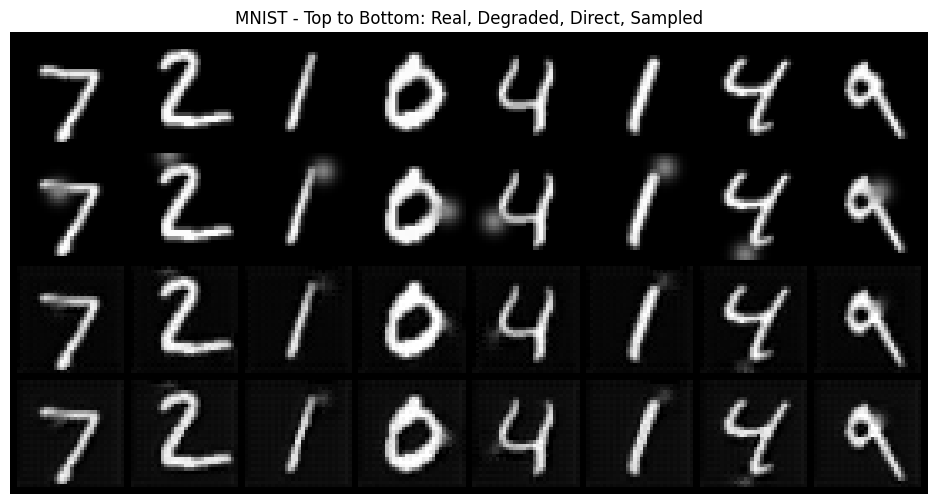


--- CIFAR10 Inpainting Evaluation ---
FID (Degraded): 11.49
FID (Direct):   28.80
FID (Sampled):  35.28
SSIM (Degraded): 0.978
SSIM (Direct):   0.930
SSIM (Sampled):  0.932
RMSE (Degraded): 0.0275
RMSE (Direct):   0.0598
RMSE (Sampled):  0.0576


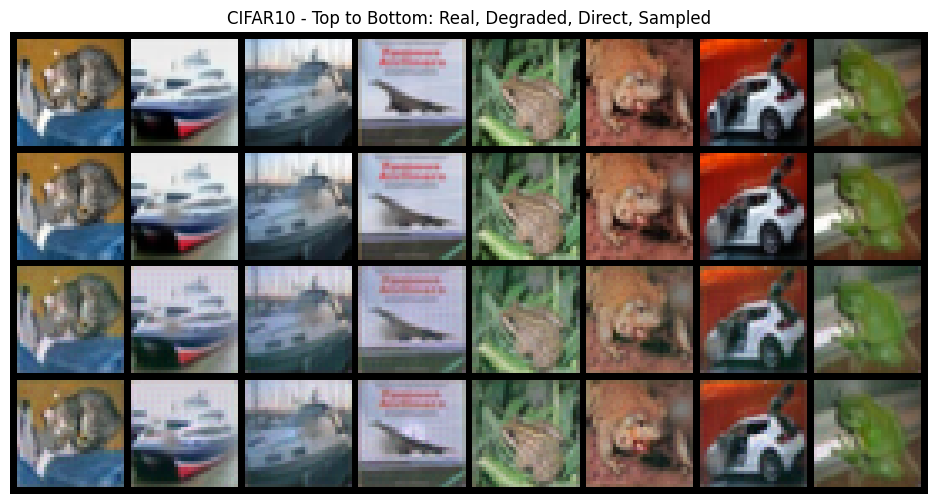

In [5]:
def degrade_inpainting(x, t, dataset_name, center=None):
    b, c, h, w = x.shape
    device = x.device

    beta1 = 1.0
    betas = [beta1 + 0.1 * i for i in range(NUM_TIMESTEPS)]

    t_indices = t.long().clamp(1, NUM_TIMESTEPS) - 1
    beta_batch = torch.tensor([betas[i] for i in t_indices], device=device)

    if center is None:
        center_x = torch.randint(0, w, (b,), device=device)
        center_y = torch.randint(0, h, (b,), device=device)
    else:
        center_x = torch.full((b,), center[0], device=device)
        center_y = torch.full((b,), center[1], device=device)

    y_coords, x_coords = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    y_coords = y_coords.expand(b, -1, -1)
    x_coords = x_coords.expand(b, -1, -1)

    dist_sq = (x_coords - center_x[:, None, None])**2 + (y_coords - center_y[:, None, None])**2
    beta_expanded = beta_batch[:, None, None]
    gaussians = torch.exp(-dist_sq / (2 * beta_expanded))
    masks = 1 - (gaussians / gaussians.amax(dim=(1, 2), keepdim=True))
    masks = masks.unsqueeze(1)

    degraded = x * masks
    degraded = torch.round(degraded * 1e8) / 1e8
    return degraded

def load_model_from_local(dataset_name, filename, device):
    model = RestorationNetwork(in_channels=1 if dataset_name == 'MNIST' else 3).to(device)
    model.load_state_dict(torch.load(os.path.join('/content', filename), map_location=device))
    model.eval()
    return model

def sample_algorithm2(model, degraded_image, num_timesteps, dataset_name):
    model.eval()
    with torch.no_grad():
        x = degraded_image.to(device)
        H, W = x.shape[1:]
        center = (W // 2, H // 2)  # fixed center for reproducibility

        for s in range(num_timesteps, 0, -1):
            t_normalized = torch.tensor([s / num_timesteps], device=device)
            x_hat_0 = model(x.unsqueeze(0), t_normalized).squeeze(0)

            if s > 1:
                D_x0_s   = degrade_inpainting(x_hat_0.unsqueeze(0), torch.tensor([s], device=device), dataset_name, center=center).squeeze(0)
                D_x0_sm1 = degrade_inpainting(x_hat_0.unsqueeze(0), torch.tensor([s - 1], device=device), dataset_name, center=center).squeeze(0)
                x = x - D_x0_s + D_x0_sm1
                x = torch.clamp(x, -1, 1)

        return x_hat_0

# for FID
def get_inception_features(images, device):
    model = inception_v3(weights='IMAGENET1K_V1').to(device)
    model.fc = torch.nn.Identity()
    model.eval()

    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)

    images_resized = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        return model(images_resized).cpu().numpy()


def compute_fid(real, fake):
    mu1, mu2 = real.mean(0), fake.mean(0)
    sigma1, sigma2 = np.cov(real, rowvar=False), np.cov(fake, rowvar=False)
    covmean = sqrtm(sigma1 @ sigma2)
    return np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * covmean.real)

def evaluate_and_visualize_local(dataset_name, model_path, num_samples=8):
    _, test_dataset = get_dataset(dataset_name)
    test_loader = DataLoader(test_dataset, batch_size=num_samples, shuffle=False)
    model = load_model_from_local(dataset_name, model_path, device)

    ema = EMA(model, EMA_DECAY)
    ema.register()
    ema.apply_shadow()

    data_iter = iter(test_loader)
    real = next(data_iter)[0].to(device)
    t_tensor = torch.full((real.size(0),), NUM_TIMESTEPS, device=device).float()
    degraded = degrade_inpainting(real, t_tensor, dataset_name)
    t_norm = t_tensor / NUM_TIMESTEPS

    with torch.no_grad():
        direct = model(degraded, t_norm)
        sampled = torch.stack([
            sample_algorithm2(model, degraded[i], NUM_TIMESTEPS, dataset_name)
            for i in range(real.size(0))
        ])

    def denorm(x):
        return x * 0.5 + 0.5

    real_np = denorm(real).cpu().numpy()
    degraded_np = denorm(degraded).cpu().numpy()
    direct_np = denorm(direct).cpu().numpy()
    sampled_np = denorm(sampled).cpu().numpy()

    # SSIM
    ssim_degraded = np.mean([
        ssim(real_np[i].transpose(1, 2, 0), degraded_np[i].transpose(1, 2, 0), data_range=1.0, channel_axis=-1)
        for i in range(num_samples)
    ])
    ssim_direct = np.mean([
        ssim(real_np[i].transpose(1, 2, 0), direct_np[i].transpose(1, 2, 0), data_range=1.0, channel_axis=-1)
        for i in range(num_samples)
    ])
    ssim_sampled = np.mean([
        ssim(real_np[i].transpose(1, 2, 0), sampled_np[i].transpose(1, 2, 0), data_range=1.0, channel_axis=-1)
        for i in range(num_samples)
    ])

    # RMSE
    rmse_degraded = np.mean([
        mse(real_np[i].squeeze(), degraded_np[i].squeeze())**0.5 for i in range(num_samples)
    ])
    rmse_direct = np.mean([
        mse(real_np[i].squeeze(), direct_np[i].squeeze())**0.5 for i in range(num_samples)
    ])
    rmse_sampled = np.mean([
        mse(real_np[i].squeeze(), sampled_np[i].squeeze())**0.5 for i in range(num_samples)
    ])

    # FID
    real_features = get_inception_features(denorm(real), device)
    degraded_features = get_inception_features(denorm(degraded), device)
    direct_features = get_inception_features(denorm(direct), device)
    sampled_features = get_inception_features(denorm(sampled), device)

    fid_degraded = compute_fid(real_features, degraded_features)
    fid_direct = compute_fid(real_features, direct_features)
    fid_sampled = compute_fid(real_features, sampled_features)

    # Print all results
    print(f"\n--- {dataset_name} Inpainting Evaluation ---")
    print(f"FID (Degraded): {fid_degraded:.2f}")
    print(f"FID (Direct):   {fid_direct:.2f}")
    print(f"FID (Sampled):  {fid_sampled:.2f}")
    print(f"SSIM (Degraded): {ssim_degraded:.3f}")
    print(f"SSIM (Direct):   {ssim_direct:.3f}")
    print(f"SSIM (Sampled):  {ssim_sampled:.3f}")
    print(f"RMSE (Degraded): {rmse_degraded:.4f}")
    print(f"RMSE (Direct):   {rmse_direct:.4f}")
    print(f"RMSE (Sampled):  {rmse_sampled:.4f}")

    # Visualize
    grid = torch.cat([real, degraded, direct, sampled], dim=0)
    grid = make_grid(denorm(grid.cpu()), nrow=num_samples)
    plt.figure(figsize=(18, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f"{dataset_name} - Top to Bottom: Real, Degraded, Direct, Sampled")
    plt.show()

evaluate_and_visualize_local('MNIST', 'MNIST_inpainting_model.pth')
evaluate_and_visualize_local('CIFAR10', 'CIFAR10_inpainting_model.pth')

